In [1]:
import os, glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mctools.core import MCSpace, MCStates, MCSpectrum
from mctools.core.utils import get_state_alignment, get_state_map_from_alignment
from mctools.parser.gaussian import parse_gdvlog, l302_parser_funcs_general, l910_parser_funcs

In [2]:
data_dir = os.path.join('data')

# Analyze CAS States

In [3]:
casscf_gdvlog = os.path.join(data_dir, 'casscf.log')

parser_funcs = l302_parser_funcs_general | l910_parser_funcs

cas_data = parse_gdvlog(casscf_gdvlog, parser_funcs)
cas_space = MCSpace.from_dict(cas_data, max_hole=0, max_elec=0)
cas_states = MCStates.from_dict(cas_data, space=cas_space)

cas_space.mo_blocks = {
    '4f': [(0, 13), 49],
    '5p': [(13, 49)]
}

cas_space.config_classes = {
    'f13': {'4f': 13, '5p': 36},
    'Lf14': {'4f': 14, '5p': 35},
}

cas_states.analyze()

Reading data/casscf.log
Parsing link l302
Executing: read_overlap_matrix
Executing: read_kinetic_energy_matrix
Executing: read_hcore_matrix
Executing: read_orthogonal_aos_matrix
Parsing link l910
Executing: read_mc_spec
Executing: read_ci
Executing: read_pdm_diags
Skipping: read_oscillator_strength, parameter n_ground is unavailable


In [4]:
cas_states.df

,E,state,source,g,norm,4f,5p,Lf14,f13
idx,,,,,,,,,
0,-56745.342439,1,data/casscf.log,0,1.0,13.040405,35.959596,0.040405,0.959595
1,-56745.342439,2,data/casscf.log,0,1.0,13.027429,35.972571,0.027430,0.972570
2,-56745.341908,3,data/casscf.log,0,1.0,13.031924,35.968076,0.031924,0.968076
3,-56745.341908,4,data/casscf.log,0,1.0,13.019910,35.980089,0.019910,0.980090
4,-56745.341905,5,data/casscf.log,0,1.0,13.036843,35.963159,0.036843,0.963157
5,-56745.341905,6,data/casscf.log,0,1.0,13.019469,35.980532,0.019469,0.980531
6,-56745.340935,7,data/casscf.log,0,1.0,13.005058,35.994945,0.005058,0.994942
7,-56745.340934,8,data/casscf.log,0,1.0,13.004808,35.995193,0.004807,0.995193
8,-56745.288809,9,data/casscf.log,1,1.0,13.144296,35.855709,0.144294,0.855706


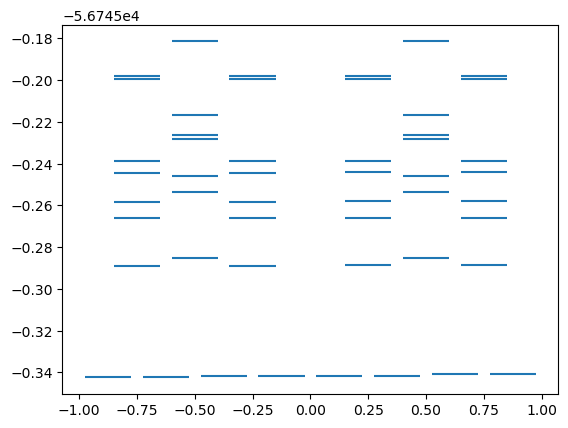

In [15]:
from mctools.plot.states import prepare_state_centers

width = 0.1
x_c = prepare_state_centers(cas_states, column_width=2)

plt.hlines('E', x_c - width, x_c + width, data=cas_states.df)
plt.show()

#  M-Edge Spectrum

In [16]:
rasci_gdvlog = os.path.join(data_dir, 'rasci_3.log')

m_edge_data = parse_gdvlog(rasci_gdvlog, l910_parser_funcs, n_ground=14)
medge_space = MCSpace.from_dict(m_edge_data, max_hole=1, max_elec=0)
medge_states = MCStates.from_dict(m_edge_data, space=medge_space)
medge_spec = MCSpectrum.from_dict(m_edge_data, states=medge_states)

medge_space.mo_blocks = {
    '3d': [(0, 10)],
    '4f': [(10, 23), 59],
    '5p': [(23, 59)],
}

medge_space.config_classes = {
    'f13': {'3d': 10, '4f': 13, '5p': 36},
    'Lf14': {'3d': 10, '4f': 14, '5p': 35},

    'f14': {'3d': 9, '4f': 14, '5p': 36},
}

medge_spec.analyze()

Reading data/rasci_3.log
Parsing link l910
Executing: read_mc_spec
Executing: read_ci
Executing: read_pdm_diags
Executing: read_oscillator_strength


In [6]:
medge_spec.states.df

,E,state,source,g,norm,3d,4f,5p,f14,f13,Lf14
idx,,,,,,,,,,,
0,-56745.342439,1,data/rasci_3.log,0,1.0,10.000000,13.040405,35.959596,0.0,0.959596,0.040404
1,-56745.342439,2,data/rasci_3.log,0,1.0,10.000000,13.027429,35.972571,0.0,0.972570,0.027430
2,-56745.341908,3,data/rasci_3.log,0,1.0,10.000000,13.031923,35.968080,0.0,0.968079,0.031921
3,-56745.341908,4,data/rasci_3.log,0,1.0,10.000000,13.019910,35.980091,0.0,0.980090,0.019910
4,-56745.341905,5,data/rasci_3.log,0,1.0,10.000000,13.036848,35.963156,0.0,0.963154,0.036846
5,-56745.341905,6,data/rasci_3.log,0,1.0,10.000000,13.019469,35.980532,0.0,0.980531,0.019469
6,-56745.340935,7,data/rasci_3.log,0,1.0,10.000000,13.005058,35.994945,0.0,0.994942,0.005058
7,-56745.340934,8,data/rasci_3.log,0,1.0,10.000000,13.004808,35.995193,0.0,0.995193,0.004807
8,-56745.288809,9,data/rasci_3.log,1,1.0,10.000000,13.144299,35.855703,0.0,0.855703,0.144297


# Partitioned K-edge Spectrum

In [7]:
spec_space = MCSpace.from_space_spec(
    ras=(12, 14, 10),
    elec=13,
    max_hole=2, max_elec=1,
    mo_blocks={
        '1s': [(0, 6)],
        '3p': [(6, 12)],
        '4f': [(12, 26)],
        '5d': [(26, 36)],
    },
)

gdvlogs = sorted(glob.glob(os.path.join(data_dir, 'spectrum', 'part*.log')))

spec_parts = []
for gdvlog in gdvlogs:
    part_data = parse_gdvlog(gdvlog, l910_parser_funcs, n_ground=2)
    spec = MCSpectrum.from_dict(part_data, space=spec_space, sort_peaks=True, )
    spec_parts.append(spec)

Reading data/spectrum/part1.log
Parsing link l910
Executing: read_mc_spec
Executing: read_ci
Executing: read_pdm_diags
Executing: read_oscillator_strength
Reading data/spectrum/part2.log
Parsing link l910
Executing: read_mc_spec
Executing: read_ci
Executing: read_pdm_diags
Executing: read_oscillator_strength


In [8]:
spec = MCSpectrum.from_spectra(spec_parts)

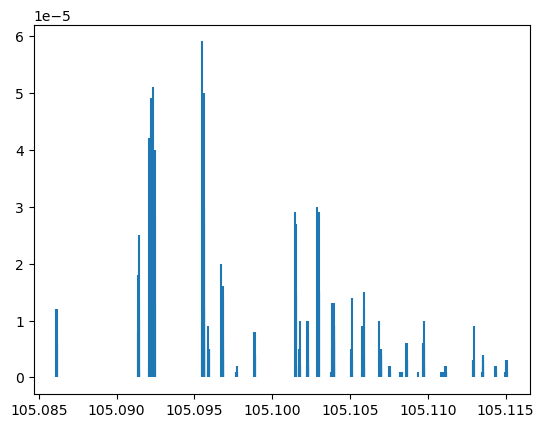

In [10]:
fig, ax = plt.subplots(1, 1)

ax.vlines('dE', 0, 'osc', data=spec.df)
plt.show()

In [6]:
spec.df

,i_state,f_state,osc,source,dE,f,i
idx,,,,,,,
0,1,2,0.000000,data/spectrum/part1.log,1.220997e-07,1,0
1,2,3,0.000000,data/spectrum/part1.log,1.050861e+02,2,1
2,1,3,0.000012,data/spectrum/part1.log,1.050861e+02,2,0
3,2,4,0.000000,data/spectrum/part1.log,1.050861e+02,3,1
4,1,4,0.000000,data/spectrum/part1.log,1.050861e+02,3,0
...,...,...,...,...,...,...,...
552,1,200,0.000000,data/spectrum/part2.log,1.051171e+02,277,0
553,2,201,0.000000,data/spectrum/part2.log,1.051172e+02,278,1
554,1,201,0.000000,data/spectrum/part2.log,1.051172e+02,278,0
